In [3]:
import pandas as pd

In [4]:
sentence_df = pd.read_csv("data/MIMIC III per sentence annotated dataset - Sheet1.csv")
sentence_df

,sentence,code
0,pt transferred to [**hospital unit name 4**] c...,J80
1,chb d/t hypothyroidism--pt with recent hx of n...,E039
2,the patient is a 67-year-old female with a his...,I4891
3,"rca, htn, gerd, left knee replacement, bipolar...",F319
4,chronic obstructive pulmonary disease diabetes...,E119
...,...,...
81022,# encephalopathy following improvement of pati...,F329
81023,"secondary progressive ms, sx onset [**8-/2167...",F329
81024,"major depressive disorder, recurrent, without ...",F329
81025,h/o major depression 3,F329


In [5]:
sentence_df.isna().sum()

sentence    0
code        0
dtype: int64

In [18]:
len(sentence_df['code'].value_counts(normalize = True))

50

<AxesSubplot:>

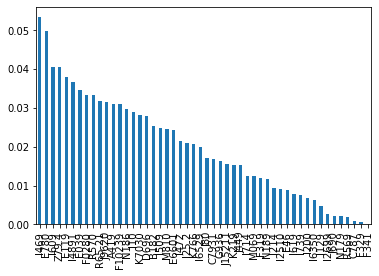

In [6]:
sentence_df['code'].value_counts(normalize = True).plot.bar()

## Text Preprocessing

In [7]:
import re

import nltk
nltk.download("all")


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/gregorykovalchuk/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/gregorykovalchuk/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/gregorykovalchuk/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/gregorykovalchuk/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/gregorykovalchuk/nltk_data...
[nltk_data]    |   Package basque_grammars is alread

In [10]:
# create a list text
preprocessed_df = sentence_df.copy(deep=True)
text = list(preprocessed_df["sentence"])
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(len(text)):

    r = re.sub("[^a-zA-Z]", " ", text[i])
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words("english")]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = " ".join(r)

    corpus.append(r)

preprocessed_df["sentence"] = corpus
preprocessed_df.head()


,sentence,code
0,pt transferred hospital unit name c respirator...,J80
1,chb hypothyroidism pt recent hx non compliance...,E039
2,patient year old female history chronic renal ...,I4891
3,rca htn gerd left knee replacement bipolar dis...,F319
4,chronic obstructive pulmonary disease diabetes...,E119


## Train-test split

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
X = preprocessed_df["sentence"]
y = preprocessed_df["code"]

tfidfconverter = TfidfVectorizer(
    max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words("english")
)
X = tfidfconverter.fit_transform(preprocessed_df["sentence"]).toarray()
X.shape


(81027, 1500)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=123
)


print("Training Data :", X_train.shape)
print("Testing Data : ", X_test.shape)


Training Data : (54288, 1500)
Testing Data :  (26739, 1500)


## Training RandomForest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [30]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)


In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

## Save model

In [ ]:
import pickle

In [ ]:
filename = "models/random_forest_model.pickle"

# save model
pickle.dump(model, open(filename, "wb"))

# # load model
# loaded_model = pickle.load(open(filename, "rb"))